# Demo de "First Order Motion Model for Image Animation" y "Motion co-Segmentation" para animar Caras y/o hacer intercambio de algunas partes
fuentes: 

https://github.com/AliaksandrSiarohin/first-order-model

https://github.com/AliaksandrSiarohin/motion-cosegmentation


1) Preparar el entorno:

In [1]:
#@title Clonar paquetes 'first-order-model' y 'motion-cosegmentation'
!git clone https://github.com/AliaksandrSiarohin/first-order-model
print("\nFirst Order Motion Model  instalado.")

!git clone https://github.com/AliaksandrSiarohin/motion-cosegmentation motion-co-seg
print("\nMotion-Cosegmentation instalado.")

Cloning into 'first-order-model'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256
Receiving objects: 100% (256/256), 72.13 MiB | 40.31 MiB/s, done.
Resolving deltas: 100% (128/128), done.

First Order Motion Model  instalado.
Cloning into 'motion-co-seg'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 97 (delta 2), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (97/97), done.

Motion-Cosegmentation instalado.


In [2]:
#@title Cargar Librerías
import sys

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

from skimage import img_as_ubyte

import PIL
from PIL import Image
from IPython.display import display as displayImage
import copy
import os

import torch
import torch.nn.functional as F
import matplotlib.patches as mpatches

print("Librerías cargadas.")

Librerías cargadas.


In [3]:
#@title Montar el drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dir = '/content/gdrive/MyDrive/IA/pruebasDeepFake'  #@param {type:"string"}
subdir_ImagenesyVideos = 'demoCaras' #@param {type:"string"}
subdir_Modelos = 'checkpoints-models' #@param {type:"string"}
dirDatos = dir + '/' + subdir_ImagenesyVideos + '/'
dirModelos = dir + '/' + subdir_Modelos + '/'

Mounted at /content/gdrive


2) Cargar y preparar imagen y video:

In [4]:
#@title Funciones Auxiliares

tamRequeridoModelo = (256, 256)

def hacerCrop(im, x_Ini, Y_Ini, X_Fin, Y_Fin, muestraMsg=True):
  
  # si está definido hace el crop
  if x_Ini > 0 and Y_Ini > 0:
    if X_Fin < x_Ini:
      X_Fin = x_Ini + 1
    if Y_Fin < Y_Ini:
      Y_Fin = Y_Ini + 1

    # determina tamaño
    width, height = im.size 
    width, height = width/100.0, height/100.0

    # realiza el crop de la imagen
    im = im.crop((int(x_Ini*width), int(Y_Ini*height), 
                  int(width*X_Fin), int(imagen_Crop_Y_Fin*height))) 

    if muestraMsg:
      print("Nuevo tamaño luego del crop: ", im.size)

  return im


def deshacerCrop(hizoCrop, imOrig, imagNueva, x_Ini, Y_Ini, X_Fin, Y_Fin):

  # si está definido hace el crop
  if hizoCrop and x_Ini > 0 and Y_Ini > 0:
    if X_Fin < x_Ini:
      X_Fin = x_Ini + 1
    if Y_Fin < Y_Ini:
      Y_Fin = Y_Ini + 1

    # determina tamaño
    width, height = imOrig.size 
    width, height = width/100.0, height/100.0

    # le hace una copia a la imagen para no perderla
    imOrigCopy = copy.deepcopy( imOrig )

    # copia una imagen en la posición correspondiente a la posición indicada
    imOrigCopy.paste(imagNueva, (int(x_Ini*width), int(Y_Ini*height)))

    return imOrigCopy  
  
  else:
    return imagNueva
      


def convImage2Array(im):
  return np.array(im).astype('float32') / 255.0


def convArray2Image(arIm, mult255=True):
  if mult255:
    multiplica = 255.0
  else:
    multiplica = 1.0
  return Image.fromarray((arIm*multiplica).astype(np.uint8))


def displayAnimacion(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        if source is None:
          cols = [ driving[0] ]
        else:
          cols = [ source] 
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani


def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')

    return color_mask

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


/content/gdrive/MyDrive/IA/pruebasDeepFake/demoCaras/zombie2.jpg
Imagen cargada.
Tamaño original:  (709, 595)
Nuevo tamaño luego del resize:  (256, 256)
Tamaño del vector de la imagen:  (256, 256, 3)




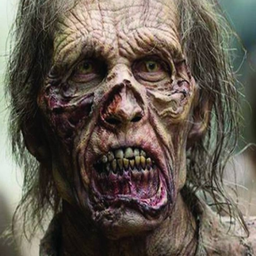

In [7]:
#@title Seleccionar y preparar la imagen

# selecciona la imagen a procesar
imagen_Seleccionada = "zombie2.jpg" #@param ['sample1-shrek.png', 'sample2-chucky.png' , 'sample3-it.png' , 'sample4-socrates.png' ,'sample5-putin.png','sample6-downeyjr.png', 'sample7-wryder.png', 'sample8.png', 'sample9.png', 'yo.png', 'yoda.jpeg', 'babyYoda.jpeg', 'zombie1.jpg', 'zombie2.jpg' ] {allow-input: false}
imagenFuente = dirDatos + imagen_Seleccionada

imagen_hace_Crop = False #@param {type:"boolean"}
imagen_Crop_X_Ini = 1 #@param {type:"slider", min:1, max:100, step:0.5}
imagen_Crop_Y_Ini = 1 #@param {type:"slider", min:1, max:100, step:0.5}
imagen_Crop_X_Fin = 100 #@param {type:"slider", min:1, max:100, step:0.5}
imagen_Crop_Y_Fin = 62 #@param {type:"slider", min:1, max:100, step:0.5}
imagen_espejada = True #@param {type:"boolean"}

# carga la imagen
print(imagenFuente)
im = Image.open( imagenFuente )
print("Imagen cargada.")

# fuerza a RGB
im = im.convert("RGB")

# obtiene el tamaño original de la imagen
imTamOri = im.size
print("Tamaño original: ", imTamOri)

# realiza imagen espejada (opcional)
if imagen_espejada:
  im = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)

if imagen_hace_Crop: 
  # genera una copia de la imagen sin crop
  imagenSinCrop = copy.deepcopy( im )
  # aplica el crop 
  im = hacerCrop(im, imagen_Crop_X_Ini, imagen_Crop_Y_Ini, imagen_Crop_X_Fin, imagen_Crop_Y_Fin)
  imTamCrop = im.size
  imHizoCrop = True
else:
  imagenSinCrop = im
  imTamCrop = imTamOri
  imHizoCrop = False

# cambia tamaño de la imagen a procesar a 256x256
im = im.resize(tamRequeridoModelo, Image.ANTIALIAS)
print("Nuevo tamaño luego del resize: ", im.size)

# cambia tamaño de la imagen sin crop
imagenSinCrop = imagenSinCrop.resize((int(imTamOri[0]/(imTamCrop[0]/tamRequeridoModelo[0])), int(imTamOri[1]/(imTamCrop[1]/tamRequeridoModelo[1]))), Image.ANTIALIAS)

# convierte imagen a vector de números
source_image = convImage2Array(im)
print("Tamaño del vector de la imagen: ", source_image.shape)

# muesta la imagen
print("\n")
displayImage(im)


/content/gdrive/MyDrive/IA/pruebasDeepFake/demoCaras/sample3-trump.mp4


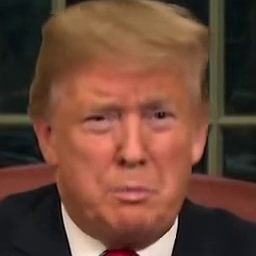

In [8]:
#@title Seleccionar el video y determina parámetros

# selecciona el video a procesar
video_seleccionado =  "sample3-trump.mp4" #@param [ 'sample1-obama.mp4', 'sample2-dicaprio.mp4', 'sample3-trump.mp4', 'sample4.mp4', 'jackNicholson.mp4', 'JimCarrey1.mp4', 'JimCarrey2.mp4'  ] {allow-input: true}
videoFuente = dirDatos + video_seleccionado
print(videoFuente)

video_hace_Crop = False #@param {type:"boolean"}
video_Crop_X_Ini = 37 #@param {type:"slider", min:1, max:100, step:0.5}
video_Crop_Y_Ini = 8 #@param {type:"slider", min:1, max:100, step:0.5}
video_Crop_X_Fin = 82.5 #@param {type:"slider", min:1, max:100, step:0.5}
video_Crop_Y_Fin = 75 #@param {type:"slider", min:1, max:100, step:0.5}

# carga video
reader = imageio.get_reader( videoFuente )
if videoFuente.find('mp4')>=0:
  fps = reader.get_meta_data()['fps']
else:
  fps = 25
driving_video = []
try:
    for imVideo in reader:
        # aplica el crop si corresponde 
        # y muestra solo la primera imagen como ejemplo
        img = convArray2Image(imVideo, mult255=False)
        if video_hace_Crop:
          img = hacerCrop(img, video_Crop_X_Ini, video_Crop_Y_Ini, video_Crop_X_Fin, video_Crop_Y_Fin)
        # cambia el tamaño de la imagen
        img = img.resize(tamRequeridoModelo, Image.ANTIALIAS)          
        displayImage(img)
        break
except RuntimeError:
    pass
reader.close()

In [9]:
#@title Preparar todo el video

# carga video
reader = imageio.get_reader( videoFuente )
if videoFuente.find('mp4')>=0:
  fps = reader.get_meta_data()['fps']
else:
  fps = 15
driving_video = []
try:
    i = 0
    for imVideo in reader:  
        # procesa los frames y las agrega al vector    
        img = convArray2Image(imVideo, mult255=False)
        # hace el crop si corresponde
        if video_hace_Crop:
          img = hacerCrop(img, video_Crop_X_Ini, video_Crop_Y_Ini, video_Crop_X_Fin, video_Crop_Y_Fin, False)
        # cambia el tamaño de la imagen
        img = img.resize(tamRequeridoModelo, Image.ANTIALIAS)
        # agrega el frame a la lista
        driving_video.append( convImage2Array(img) )      
except RuntimeError:
    pass
reader.close()

print("Video cargado.")
print("Duración del video total: ", len(driving_video), " frames.")

# cambia tamaño del video a 256x256
##driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# muestra imagen con video
HTML(displayAnimacion(source_image, driving_video).to_html5_video())

Video cargado.
Duración del video total:  211  frames.


3) Genera la animación de la cara de la imagen con gesto del video:

In [10]:
#@title Cargar checkpoint del modelo 'first-order-mode' ya entrenado

if '/content/motion-co-seg' in sys.path:
  sys.path.remove('/content/motion-co-seg')
if '/content/motion-co-seg/modules' in sys.path:
  sys.path.remove('/content/motion-co-seg/modules')
# tiene que borrar este modulo que está en ambos paquetes 
# pero con diferente veriones
if "logger" in sys.modules:
  del sys.modules["logger"]

sys.path.append('/content/first-order-model')
sys.path.append('/content/first-order-model/modules')
from demo import make_animation
from demo import load_checkpoints as fom_load_checkpoints


print("Librerías cargadas de 'first-order-mode'.")


generator, kp_detector = fom_load_checkpoints(config_path = '/content/first-order-model/config/vox-256.yaml', 
                            checkpoint_path = dirModelos + 'vox-cpk.pth.tar')

print("Modelo 'first-order-mode' cargado.")

Librerías cargadas de 'first-order-mode'.
Modelo 'first-order-mode' cargado.


In [11]:
#@title Aplica el modelo para generar nueva animación

# genera animación aplicando el modelo
tipo_Desplazamiento = 'relativo'  #@param ['relativo', 'absoluto']
if tipo_Desplazamiento == 'relativo': 
  # usa desplazamientos relativos (queda mejor)
  predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)
else:
  # usa desplazamientos relativos (queda deformado)
  predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, adapt_movement_scale=True)

# muestra la animación
HTML(displayAnimacion(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:08<00:00, 24.56it/s]


In [ ]:
#@title Agrega bordes de la imagen en la animación (si corresponde)

animacion = []
if imHizoCrop:
  
  # toma los frames de la animación generada
  # y las inserta dentro de la imagen original
  # para generar animación mejorada
  for imP in predictions:
    img = convArray2Image(imP, mult255=True)
    nImag = deshacerCrop(imHizoCrop, imagenSinCrop, img, imagen_Crop_X_Ini, imagen_Crop_Y_Ini, imagen_Crop_X_Fin, imagen_Crop_Y_Fin)
    animacion.append( convImage2Array(nImag) ) 
else:
  # como no se hizo crop, no hace nada
  animacion = predictions

HTML(displayAnimacion(None, animacion).to_html5_video())  

In [14]:
#@title Exporta la animación

if animacion == None:
  animacion = predictions

# graba el video para poder bajarlo (opcional)
tipoExportacion = "no" #@param ["no", "GIF", "MP4"]
if tipoExportacion != "no":
  expName = '/content/' + 'vfake_' + tipo_Desplazamiento[:3] + '_' + os.path.splitext(imagen_Seleccionada)[0] + '_' + os.path.splitext(video_seleccionado)[0]   
  if tipoExportacion == "MP4":
    expName = expName + '.mp4'
  elif tipoExportacion == "GIF":
    expName = expName + '.gif'
  imageio.mimsave(expName, [img_as_ubyte(frame) for frame in animacion], fps=fps)
  print(expName, " generado en el disco temporal del ambiente.")

HTML(displayAnimacion(None, animacion).to_html5_video())

4) Genera la animación con intercambio de elementos:

In [15]:
#@title Cargar checkpoint del modelo 'motion-co-seg' ya entrenado


if '/content/first-order-model' in sys.path:
  sys.path.remove('/content/first-order-model')
if '/content/first-order-model/modules' in sys.path:
  sys.path.remove('/content/first-order-model/modules')
# tiene que borrar este modulo que está en ambos paquetes 
# pero con diferente veriones
if "logger" in sys.modules:
  del sys.modules["logger"]

sys.path.append('/content/motion-co-seg')
sys.path.append('/content/motion-co-seg/modules')
from part_swap import load_checkpoints as swap_load_checkpoints
from part_swap import make_video

print("Librerías cargadas de 'motion-co-seg'.")

#%cd /content/motion-co-seg
tipo_checkpoint_de_intercambio = "10 segmentos" 
if  tipo_checkpoint_de_intercambio == "10 segmentos":
  configSgmt = '/content/motion-co-seg/config/vox-256-sem-10segments.yaml'
  chpntSgmto = dirModelos + 'vox-10segments.pth.tar'
# Nota: hay también de 5 y 15 segmentos pero como ejemplo se usa solo este
# en caso que se desea usar alguno de los otros, bajar de la fuente y subir al drive

reconstruction_module, segmentation_module = swap_load_checkpoints(config = configSgmt, 
                                               checkpoint = chpntSgmto,
                                               blend_scale = 1)

print("Modelo 'motion-co-seg' cargado.")

Librerías cargadas de 'motion-co-seg'.
Modelo 'motion-co-seg' cargado.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


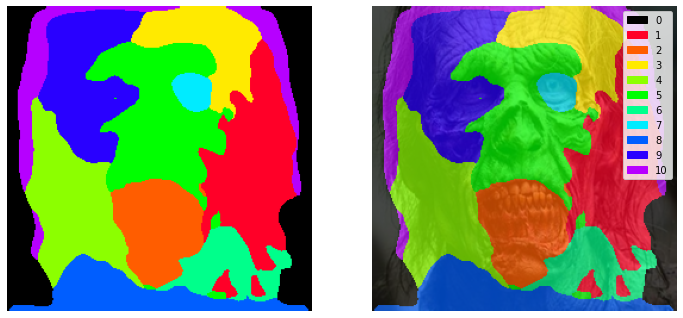

In [16]:
#@title Mostrar segmentos detectados en la imagen

%matplotlib inline
visualize_segmentation(source_image, segmentation_module, hard=True)
plt.show()


In [17]:
#@title Aplica los segmentos seleccionados de la imagen en el video

lista_segmentos_intercambiar = "9,5,7,4,2" #@param {type:"string"}
swap_index_list = np.array(lista_segmentos_intercambiar.split(",")).astype(np.uint8)
if len(swap_index_list) == 0:
  swap_index_list.append( 1 )
else:
  swap_index_list.sort()

# genera animación aplicando las partes seleccionadas de la imagen
swap_predictions = make_video(swap_index=swap_index_list.tolist(), source_image = source_image, target_video = driving_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)

# muestra la animación
HTML(displayAnimacion(source_image, driving_video, swap_predictions).to_html5_video())

100%|██████████| 211/211 [00:09<00:00, 22.26it/s]


In [ ]:
#@title Exporta la animación
# graba el video para poder bajarlo (opcional)
tipoExportacion = "no" #@param ["no", "GIF", "MP4"]
if tipoExportacion != "no":
  expName = '/content/' + 'vfake_swap_' + os.path.splitext(imagen_Seleccionada)[0] + '_' + os.path.splitext(video_seleccionado)[0]   
  if tipoExportacion == "MP4":
    expName = expName + '.mp4'
  elif tipoExportacion == "GIF":
    expName = expName + '.gif'
  imageio.mimsave(expName, [img_as_ubyte(frame) for frame in swap_predictions], fps=fps)
  print(expName, " generado en el disco temporal del ambiente.")

HTML(displayAnimacion(None, swap_predictions).to_html5_video())